### Tiny CNN

After checking the performance of the baseline model and EDA, we would want to go with a relatively smaller CNN network as anything large will be prone to overfitting


In [63]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from time import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
import numpy as np

#### Dataloader and Dataset Classes

In [53]:
class SquareDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file)
        self.data = df[["filepath", "label"]].values.tolist()  # ensures order
        self.transform = transform
        self.label_map = {'a': 0, 'b': 1, 'c': 2}

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.label_map[label]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

# Image transform (resize to 64x64, normalize to [0,1])
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor()
])

train_ds = SquareDataset("splits/train.csv", transform=transform)
val_ds = SquareDataset("splits/val.csv", transform=transform)
full_ds = SquareDataset("splits/full_val.csv", transform=transform)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64)
full_val_dl = DataLoader(full_ds, batch_size=64)


#### Configuing the Model

In [17]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # [B, 16, 64, 64]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # [B, 16, 32, 32]

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # [B, 32, 32, 32]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),       # [B, 32, 16, 16]
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 16 * 16, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 3)  # 3 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

#### Training Loop

In [35]:
def train_model(model, train_dl, val_dl, epochs=30, lr=1e-3, patience=20, model_path="best_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dl)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                val_loss = criterion(output, yb)
                total_val_loss += val_loss.item()

                preds = output.argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        avg_val_loss = total_val_loss / len(val_dl)
        val_losses.append(avg_val_loss)
        val_acc = correct / total

        print(f"\rEpoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}", end='')

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
                break
        print()  # move to next line for next epoch

    # Load best model
    model.load_state_dict(torch.load(model_path))

    # Plot losses
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


Epoch 01 | Train Loss: 1.0968 | Val Loss: 1.0920 | Val Acc: 0.5500
Epoch 02 | Train Loss: 1.0962 | Val Loss: 1.0828 | Val Acc: 0.4017
Epoch 03 | Train Loss: 1.0776 | Val Loss: 1.0682 | Val Acc: 0.5850
Epoch 04 | Train Loss: 1.0620 | Val Loss: 1.0451 | Val Acc: 0.6400
Epoch 05 | Train Loss: 1.0386 | Val Loss: 1.0116 | Val Acc: 0.5950
Epoch 06 | Train Loss: 1.0060 | Val Loss: 0.9650 | Val Acc: 0.6750
Epoch 07 | Train Loss: 0.9602 | Val Loss: 0.9145 | Val Acc: 0.6183
Epoch 08 | Train Loss: 0.9122 | Val Loss: 0.8518 | Val Acc: 0.6467
Epoch 09 | Train Loss: 0.8481 | Val Loss: 0.7875 | Val Acc: 0.6967
Epoch 10 | Train Loss: 0.7880 | Val Loss: 0.7337 | Val Acc: 0.6967
Epoch 11 | Train Loss: 0.7541 | Val Loss: 0.6951 | Val Acc: 0.7650
Epoch 12 | Train Loss: 0.7057 | Val Loss: 0.6362 | Val Acc: 0.7733
Epoch 13 | Train Loss: 0.6637 | Val Loss: 0.5987 | Val Acc: 0.8050
Epoch 14 | Train Loss: 0.6291 | Val Loss: 0.5572 | Val Acc: 0.8017
Epoch 15 | Train Loss: 0.5938 | Val Loss: 0.5245 | Val Acc: 0.

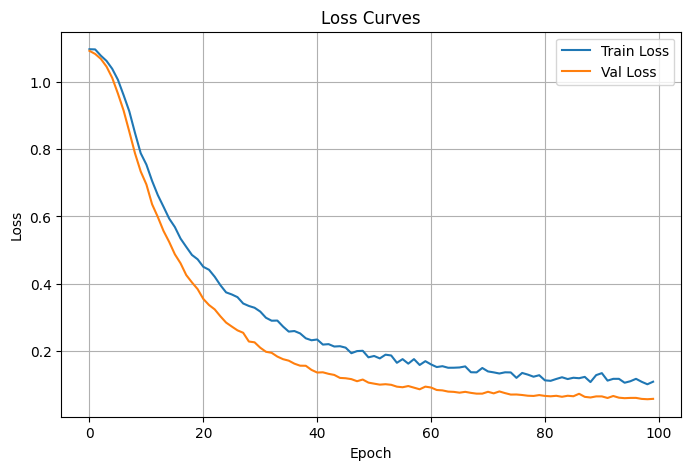

In [45]:
model = TinyCNN()
model = train_model(model, train_dl, val_dl, epochs=100)

#### Evaluation

CNN Classification Report (Val Set - TinyCNN):
              precision    recall  f1-score   support

           a    0.96680   0.99000   0.97826       500
           b    0.98956   0.94800   0.96834       500
           c    0.98232   1.00000   0.99108       500

    accuracy                        0.97933      1500
   macro avg    0.97956   0.97933   0.97923      1500
weighted avg    0.97956   0.97933   0.97923      1500



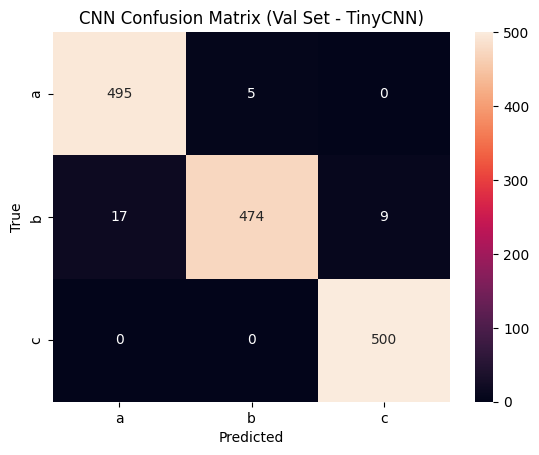

In [54]:
def evaluate(model, dl):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            preds = model(xb).argmax(1).cpu().numpy()
            preds_all.extend(preds)
            labels_all.extend(yb.numpy())
    return preds_all, labels_all

model = TinyCNN()
model.load_state_dict(torch.load("best_model.pth"))
preds_test, labels_test = evaluate(model, full_val_dl)
print("CNN Classification Report (Val Set - TinyCNN):")
print(classification_report(labels_test, preds_test, target_names=['a', 'b', 'c'], digits=5))

# Confusion Matrix
cm = confusion_matrix(labels_test, preds_test)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['a', 'b', 'c'], yticklabels=['a', 'b', 'c'])
plt.title("CNN Confusion Matrix (Val Set - TinyCNN)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

What did the model learn?

In [57]:
model

TinyCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

Using test image: data/val/b/484.png | Label: b


/opt/homebrew/Caskroom/miniconda/base/envs/cv/lib/python3.10/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


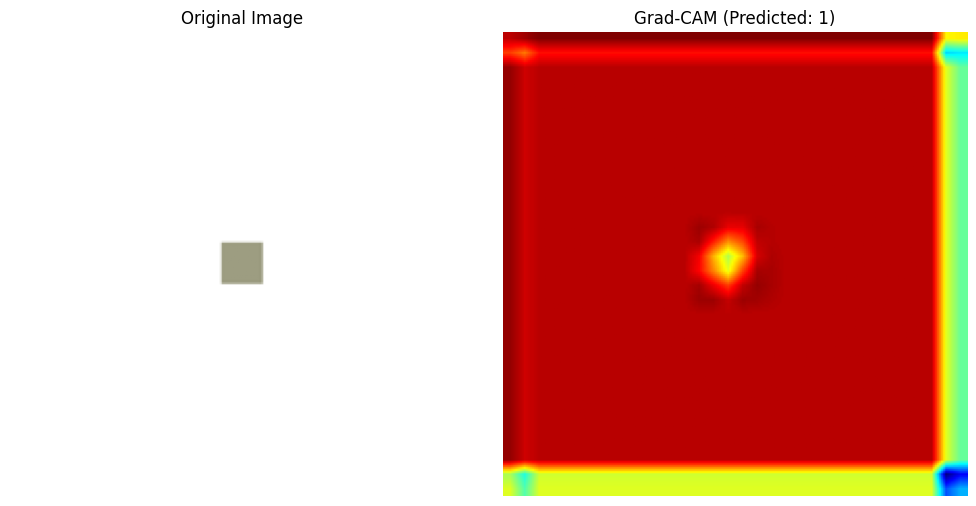

In [72]:
# Load image path from test.csv
df = pd.read_csv("splits/full_val.csv")
sample_path = df.iloc[800]['filepath']
sample_label = df.iloc[800]['label']
print("Using test image:", sample_path, "| Label:", sample_label)

# Image transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
image = Image.open(sample_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0)

# Load model
model = TinyCNN()
model.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
model.eval()

# --- Grad-CAM Hooks ---
activations = {}
gradients = {}

def forward_hook(module, input, output):
    activations['value'] = output.detach()

def backward_hook(module, grad_input, grad_output):
    gradients['value'] = grad_output[0].detach()

# Register hooks on last conv layer
target_layer = model.features[3]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# Forward + backward pass
output = model(input_tensor)
pred_class = output.argmax().item()
score = output[0, pred_class]
model.zero_grad()
score.backward()

# Grad-CAM: compute and normalize
grads = gradients['value']               # [B, C, H, W]
acts = activations['value']             # [B, C, H, W]
weights = grads.mean(dim=(2, 3))        # [B, C]

cam = (weights[:, :, None, None] * acts).sum(dim=1).squeeze()
cam = F.relu(cam)
cam -= cam.min()
cam /= cam.max()
cam = cam.numpy()

# Resize CAM and overlay
cam_resized = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255.0
img_np = np.array(image.resize((224, 224))) / 255.0
overlay = heatmap
overlay = np.clip(overlay, 0, 1)

# Show Grad-CAM
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title(f"Grad-CAM (Predicted: {pred_class})")
plt.axis("off")
plt.tight_layout()
plt.show()


#### Additional Network tried

In [31]:
import torch.nn as nn

class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 32x32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
